Best Parameters: {'learning_rate': np.float64(0.18665605178377367), 'max_depth': 4, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 430, 'subsample': np.float64(0.9720485324637261)}
R2 Score: 0.9825325633322938
RMSE: 2293.6235415143146


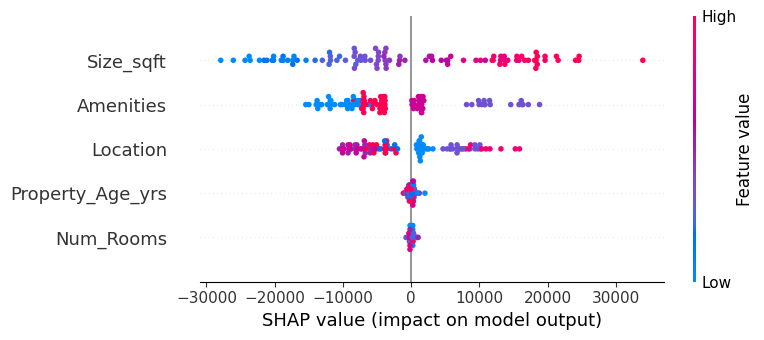

Predicted Price (Lakhs) for new property: 56901.13
Actual Price: 47176.78 Lakhs | Predicted Price: 46954.07 Lakhs
Actual Price: 22997.81 Lakhs | Predicted Price: 23336.68 Lakhs
Actual Price: 28674.8 Lakhs | Predicted Price: 32626.68 Lakhs
Actual Price: 40971.39 Lakhs | Predicted Price: 39971.64 Lakhs
Actual Price: 53590.79 Lakhs | Predicted Price: 55947.07 Lakhs


['le_amenities.pkl']

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
import shap
import joblib
from scipy.stats import uniform, randint

# Load data
df = pd.read_csv('properties.csv')

# Encode categorical columns
le_location = LabelEncoder()
le_amenities = LabelEncoder()
df['Location'] = le_location.fit_transform(df['Location'])
df['Amenities'] = le_amenities.fit_transform(df['Amenities'])

# Split features and target
X = df.drop('Price_in_Lakhs', axis=1)
y = df['Price_in_Lakhs']

# Scale data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Hyperparameter optimization using RandomizedSearchCV
param_dist = {
    'n_estimators': randint(200, 600),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 8),
    'min_samples_split': randint(2, 10),
    'min_samples_leaf': randint(1, 6),
    'subsample': uniform(0.7, 0.3)
}

model = GradientBoostingRegressor(random_state=42)
random_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=50, cv=3, scoring='r2', n_jobs=-1, random_state=42)
random_search.fit(X_train, y_train)

model = random_search.best_estimator_
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

# Evaluation
print('Best Parameters:', random_search.best_params_)
print('R2 Score:', r2_score(y_test, y_pred))
print('RMSE:', np.sqrt(mean_squared_error(y_test, y_pred)))

# SHAP Feature Importance
explainer = shap.Explainer(model)
shap_values = explainer(X_test)
shap.summary_plot(shap_values, X_test, feature_names=X.columns)

# Predict price for new property
new_property = pd.DataFrame({
    'Location': [le_location.transform(['Mumbai'])[0]],
    'Size_sqft': [2000],
    'Num_Rooms': [4],
    'Property_Age_yrs': [3],
    'Amenities': [le_amenities.transform(['Luxury'])[0]]
})
new_scaled = scaler.transform(new_property)
price_prediction = model.predict(new_scaled)
print('Predicted Price (Lakhs) for new property:', round(price_prediction[0], 2))

# Example of actual vs predicted
example_data = X_test[:5]
example_actual = y_test[:5].values
example_pred = model.predict(example_data)
for i in range(5):
    print(f"Actual Price: {round(example_actual[i], 2)} Lakhs | Predicted Price: {round(example_pred[i], 2)} Lakhs")

# Save artifacts
joblib.dump(model, 'house_price_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(le_location, 'le_location.pkl')
joblib.dump(le_amenities, 'le_amenities.pkl')